## Next Reaction method simulation for 2D root development

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook

In /home/camillalyons/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/camillalyons/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/camillalyons/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# giu' su sinistra destra
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [0,8,0,0], [0,8,0,0] 
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [8,0,0,12], [8,0,12,0]
vascular = [8,0,0,0]


P_out = np.zeros((22,12,4))

# 22 rows, 12 columns. The first is the upmost cell in the tip

# cinta esterna della radice (muraria)
P_out[0,:,:]=[0,0,0,0]
# this cells can only pass auxin to vascular and border
P_out[-1,:,:]=[8,0,0,0]
P_out[:,0,:]=[0,0,0,0]
P_out[:,-1,:]=[0,0,0,0]

# in futuro aggiungeremo un flusso di auxina dallo shoot

# defining colummellas
P_out[1:4,1:11] = colummella

# defining epidermal
P_out[4:21,1:3] = epidermal_l
P_out[4:21,9:11] = epidermal_r

# defining border
P_out[4:21,3] = border_l
P_out[4:21,8] = border_r

# defining vascular
P_out[4:21,4:8] = vascular

# defining QC in position [4,4:8] same PIN settings as vascular


In [3]:
D=1.4
T=0.6

In [20]:
def update_2D(cells, dt, source=(4,4), source_val=10, D=D, T=T, P_out=P_out, decay=0.000005, upper_bound=5000):
    """
    updates vector of cells following equation (1)

    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_out : numpy matrix (lenght,width,4), amount of PIN1 that a cell outtakes to every neighbour (down, up, left, right)
    """
    # define neighbours
    v = np.array([[1,0], [-1,0], [0,-1], [0,1]])
    updated_cells = cells
    cells_flux = np.zeros((2,len(cells),12))
    
    initial_concentrations = sum(sum(cells))
    qc = 0
    step_tot=0
    
    for i, value in enumerate(cells[1:21], 1):
        step = np.zeros(cells.shape[1])
        step_direction_flux = np.zeros((2,cells.shape[1]))
        for j in range(1,len(cells[i])-1):
            neighbours = [cells[k]/96 for k in tuple(map(tuple, v + [i,j]))]
            
            auxin_square = value[j]/96
            #aux_decay = -decay*value[j]            
            D_out = D*(1/20)
            
            #apoplast
            apoplast_down_neighbour =  [neighbours[0]*8*D_out if P_out[i-1,j,1]==0 else T*P_out[i-1,j,1]*neighbours[0]*8][0]
            apoplast_down_me = [auxin_square*8*D_out if P_out[i,j,0]==0 else T*P_out[i,j,0]*auxin_square*8][0]
            apoplast_down = apoplast_down_neighbour + apoplast_down_me
    
            apoplast_up_neighbour =  [neighbours[1]*8*D_out if P_out[i+1,j,0]==0 else T*P_out[i+1,j,0]*neighbours[1]*8][0]
            apoplast_up_me = [auxin_square*8*D_out if P_out[i,j,1]==0 else T*P_out[i,j,1]*auxin_square*8][0]
            apoplast_up = apoplast_up_neighbour + apoplast_up_me
    
            apoplast_left_neighbour = [neighbours[2]*12*D_out if  P_out[i, j-1, 3]==0 else T*P_out[i, j-1, 3]*neighbours[2]*12][0]
            apoplast_left_me = [auxin_square*8*D_out if P_out[i,j,2]==0 else T*P_out[i,j,2]*auxin_square*12][0]
            apoplast_left = apoplast_left_neighbour + apoplast_left_me
    
            apoplast_right_neighbour = [neighbours[3]*12*D_out if P_out[i, j+1, 2]==0 else T*P_out[i, j+1, 2]*neighbours[3]*12][0]
            apoplast_right_me = [auxin_square*12*D_out if P_out[i,j,3]==0 else T*P_out[i,j,3]*auxin_square*12][0]
            apoplast_right = apoplast_right_neighbour + apoplast_right_me
            
            # diffusion in
            diffusion_in_down= D*apoplast_down
            diffusion_in_up= D*apoplast_up
            diffusion_in_left= D*apoplast_left
            diffusion_in_right= D*apoplast_right
            diffusion_in_total = diffusion_in_down + diffusion_in_left + diffusion_in_right + diffusion_in_up
            
            # transport out: don't give to neighbou if he exceeds the upper bound
            transport_out_down = -T*P_out[i,j,0]*auxin_square*8
            transport_out_up =  -T*P_out[i,j,1]*auxin_square*8
            transport_out_left =  -T*P_out[i,j,2]*auxin_square*12
            transport_out_right = -T*P_out[i,j,3]*auxin_square*12
            transport_out_total = transport_out_down + transport_out_left + transport_out_right + transport_out_up
            
            # diffusion_out = -(1/20)*sum([1/(i) if i != 0 else 0 for i in neighbours])*D*value[j]
            diffusion_out_down = [auxin_square*8*(-D_out) if P_out[i,j,0] == 0 else 0][0]
            diffusion_out_up = [auxin_square*8*(-D_out) if P_out[i,j,1] == 0 else 0][0]
            diffusion_out_left = [auxin_square*12*(-D_out) if P_out[i,j,2] == 0 else 0][0]
            diffusion_out_right = [auxin_square*12*(-D_out) if P_out[i,j,3] == 0 else 0][0]
                
                
            # these are the cases in which the cell is at an extremity: we don't have diffusion outside of the root itself
            if i == 1:
                diffusion_out_down, transport_out_down = 0,0
            if j==1:
                diffusion_out_left, transport_out_left = 0,0
            if j==10:
                diffision_out_right, diffusion_out_right = 0,0
            
            diffusion_out_total = diffusion_out_down + diffusion_out_left + diffusion_out_right + diffusion_out_up 
            
            x_coord = (abs(transport_out_left)-abs(transport_out_right))
            y_coord = (abs(transport_out_up)-abs(transport_out_down))
            step_direction_flux[:,j] = (x_coord, y_coord)
              
            
            # last piece is the basal auxin production of each cell (a.u./(micrometers^2*sec))
            step[j] = transport_out_total + diffusion_out_total + diffusion_in_total
            if step[j] <= 0:
                step[j] = 8*12*0.0005*4
            step_tot += step[j]
            
            step[j] = value[j] + step[j]     
             
            if i==3 and j==5:
                qc+=step[j]
                
        updated_cells[i,:] = [0] + step + [0]
        cells_flux[:,i,:] = [0] + step_direction_flux + [0]
    
    
    updated_cells[source[0], source[1]:source[1]+4] += source_val*8*12*dt
    
    #print(initial_concentrations, sum(sum(updated_cells)), step_tot+source_val*8*12*4)
    return updated_cells,cells_flux, qc

<IPython.core.display.Javascript object>


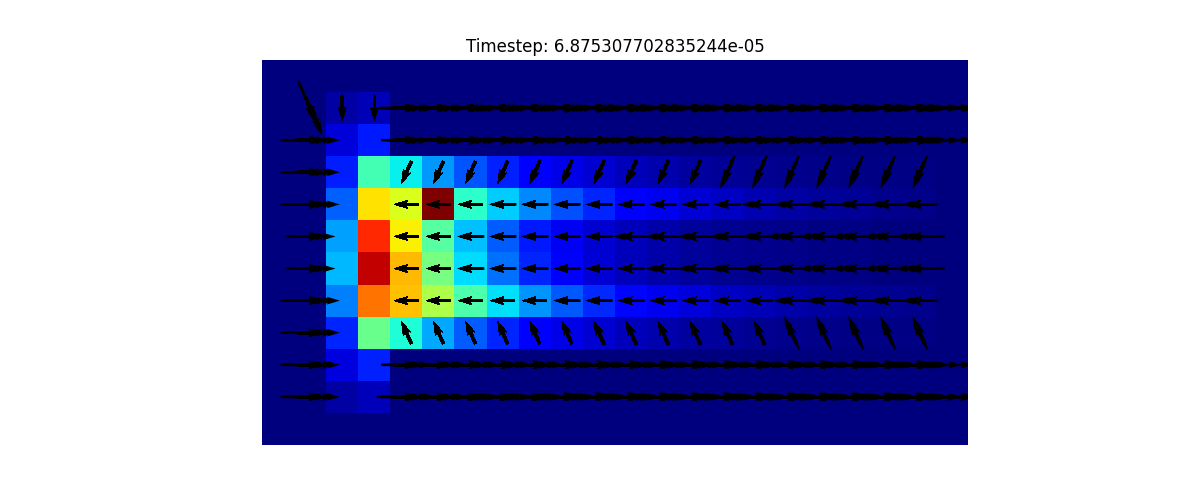

/home/camillalyons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/camillalyons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/camillalyons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
/home/camillalyons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in add
/home/camillalyons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in square
/home/camillalyons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in add
/home/camillalyons/.local/lib/python3.6/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/camillalyons/.lo

In [ ]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((22,12))*20
cells_a[0,:]=0
cells_a[-1, 3:9]=70
cells_a[:,0]=0
cells_a[:,-1]=0
# QC cell starts with an initial amount of auxin
#cells_a[3][1] = 10
cells_a[4,4:8] = 100
fig= plt.figure(figsize=(12,5)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells_a.T, cmap="jet")
cells_out = cells_a

T = []
t = 0
sim_time=0.0001
while t<sim_time:
    cells_prev=cells_out    #need to keep track of the previous state
    cells_out, cells_fluxes, qc = update_2D(cells_out, dt=0.5, T=0.6, D=1.4)
    #auxin production and decay happe independently from the reaction that is fired: apply them to all cells
    for cell_row in cells_out:
        for cell in cell_row:
            cell+=  8*12*0.0005*4 - cell*0.000005    #production - degradation of auxin
    
    ## NRM
    z1 = np.random.uniform(0,1)
    acum = np.cumsum(cells_out)
    atot = acum[-1] 
    tau = -np.log(z1)/np.sum(cells_out) 
    z2 = np.random.uniform(0,1)
    zatot = z2*atot
    mu = np.where(acum>zatot)[0][0] 
    cells_prev[mu//12][mu%12] = cells_prev[mu//12][mu%12] + cells_out[mu//12][mu%12] #only one cell will be updated
    cells_out=cells_prev
    t = t + tau 
    T.append(t)
    
    plt.imshow(cells_out.T, cmap="jet") 
    U = cells_fluxes[1,:,:].T
    V = cells_fluxes[0,:,:].T
    U_norm = U / np.sqrt(U**2 + V**2)
    V_norm = V / np.sqrt(U**2 + V**2)
    
    plt.quiver(U_norm, V_norm, pivot='mid')

    plt.title(f"Timestep: {str(t)}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()
    if t>sim_time:
        plt.clf() ##to avoid the clearance of the plot